Импортируем модули и читаем данные

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [4]:
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=["year"], index_col = ["year"])
data = data.rename(columns={'GDP (current US$)': 'gdp'})
data.head()

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<AxesSubplot:xlabel='year'>

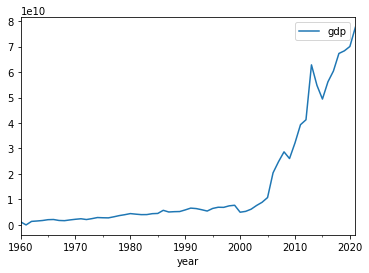

In [5]:
%matplotlib inline 
data.plot()

Отложим последние три года датасета как тестовую выборку для оценки результатов предсказания.

In [6]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

Проанализируем временной ряд на наличие тренда и сезонности, выполнив сезонную декомпозицию.

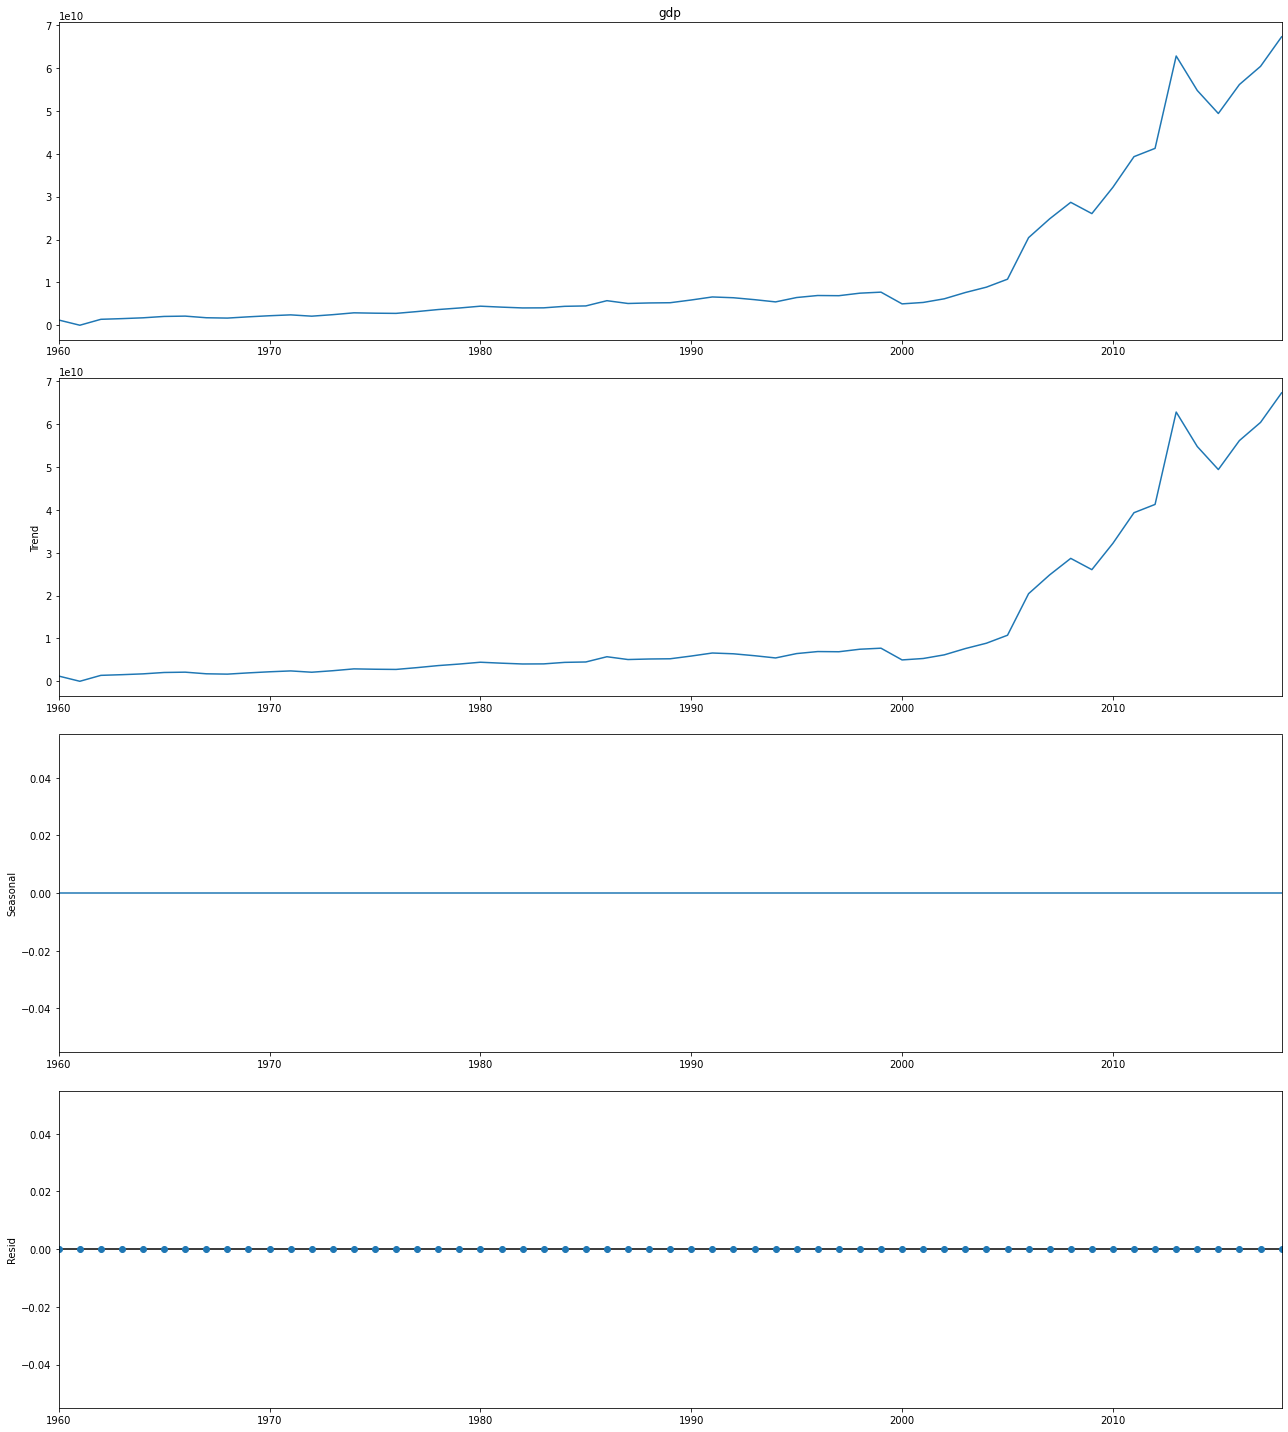

In [7]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df["gdp"], model='additive')
result.plot()
plt.show()

Сезонность и остатки (шум) отсутствуют.

Построим скользящее среднее.

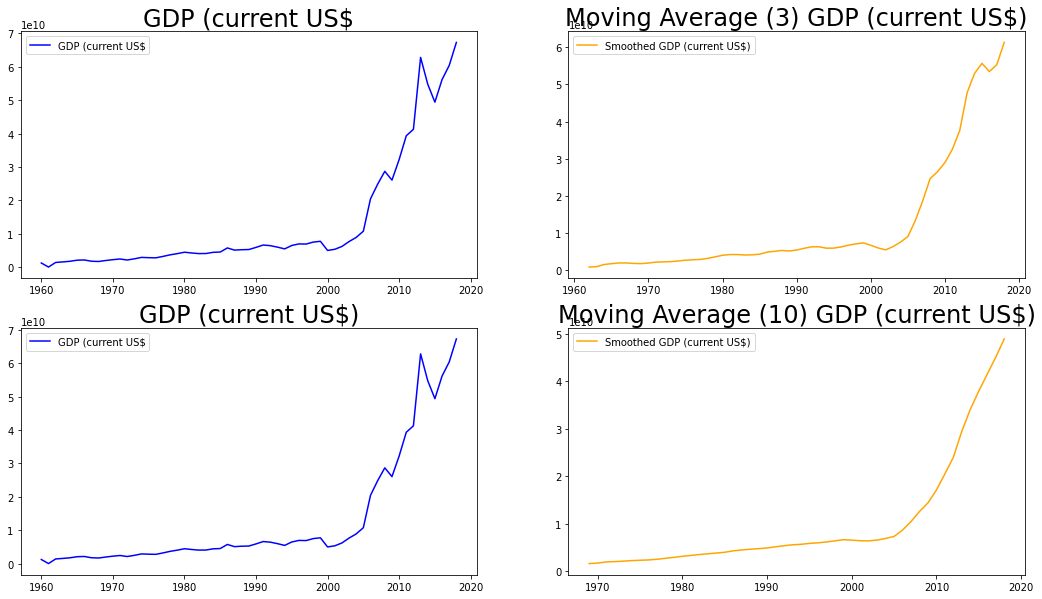

In [8]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в техлетие (Window = 3) 
ax[0, 0].plot(train_df["gdp"], color = "blue", label = "GDP (current US$")
ax[0, 0].set_title("GDP (current US$", size = 24)
ax[0, 0].legend()

ax[0, 1].plot(train_df["gdp"].rolling(window=3).mean(), color = "orange", label = "Smoothed GDP (current US$)")
ax[0, 1].set_title("Moving Average (3) GDP (current US$)", size = 24)
ax[0, 1].legend()


# Окно в десятилетие (Window = 10)
ax[1, 0].plot(train_df["gdp"], color = "blue", label = "GDP (current US$")
ax[1, 0].set_title("GDP (current US$)", size = 24)
ax[1, 0].legend()

ax[1, 1].plot(train_df["gdp"].rolling(window=10).mean(), color = "orange", label = "Smoothed GDP (current US$)")
ax[1, 1].set_title("Moving Average (10) GDP (current US$)", size = 24)
ax[1, 1].legend()

Построим коррелограмму для временного ряда

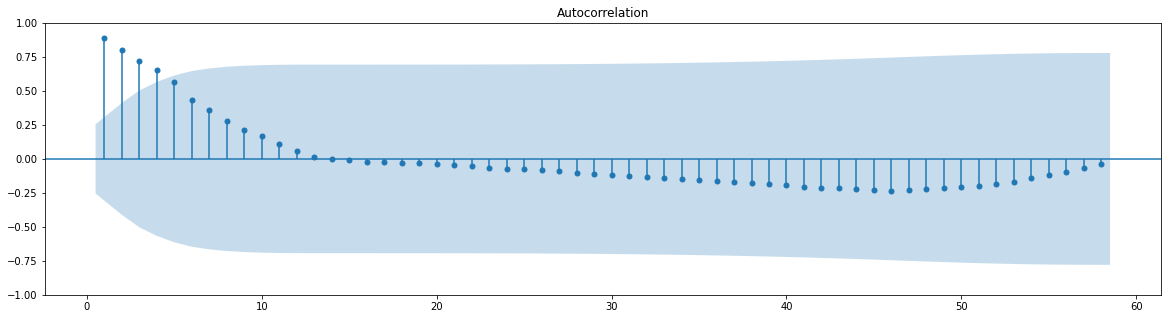

In [9]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df["gdp"], zero = False, lags = 58)
plt.show()

Корелляция данных уменьшается со временем.

Построим график частичной автокорелляции.

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


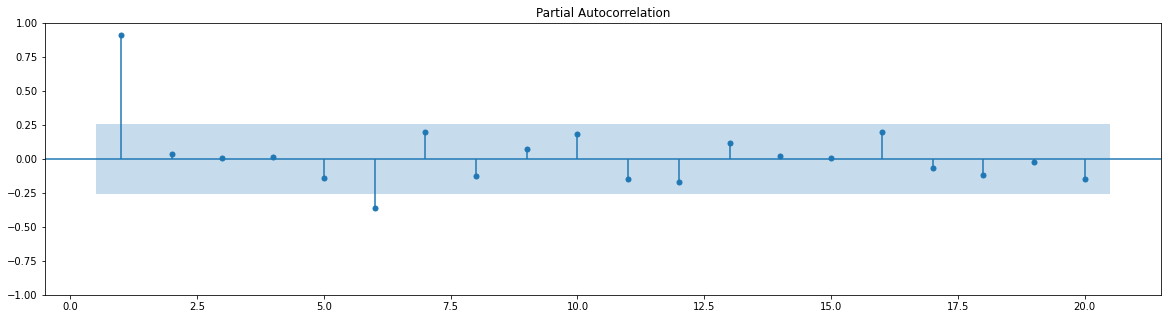

In [10]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df["gdp"], zero = False, lags = 20)
plt.show()

Данные ВВП с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1


In [11]:
adfuller(train_df["gdp"])

(0.6529066974885368,
 0.9888496277665573,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

In [12]:
test1 = adfuller(train_df["gdp"])
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')


adf:  0.6529066974885368
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому данные ВВП не являются стационарными, присутсвует тренд.

In [13]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, lags = 50, ax = axes[0])
    sgt.plot_pacf(series, lags = 27, ax = axes[1])
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

где, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


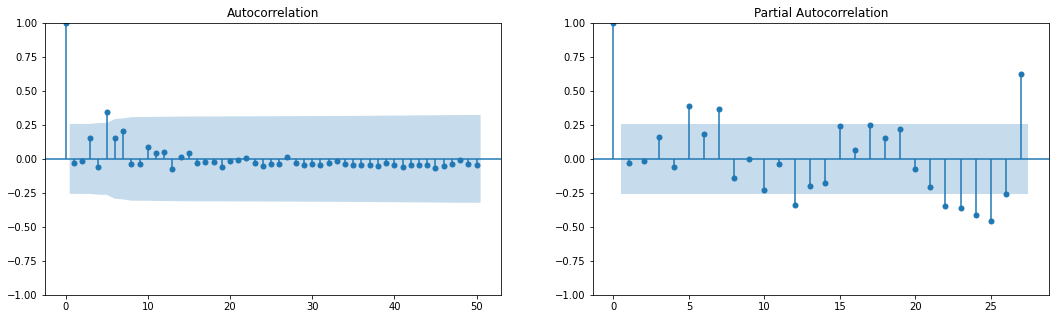

adf:  -1.6702483038320775
p-value:  0.4465029329713892
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


In [14]:
plot_acf_pacf(train_df["gdp"].diff(1).dropna())
test = adfuller(train_df["gdp"].diff(1).dropna())
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])

Первые разности не являются стационарными

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


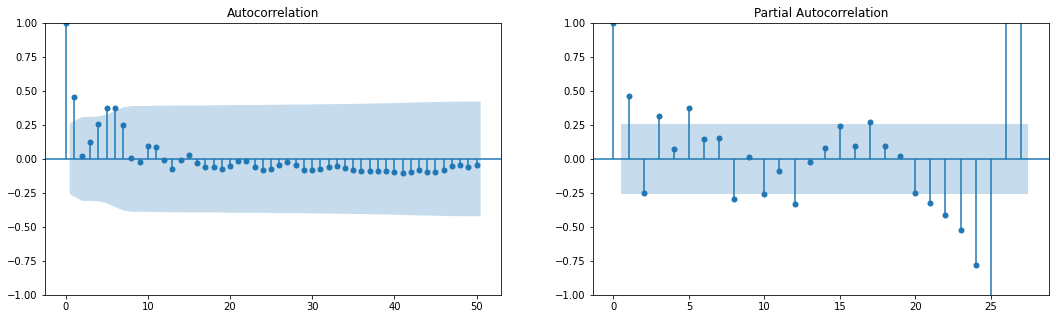

adf:  -3.5836708658260297
p-value:  0.006080989753876958
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}


In [15]:
plot_acf_pacf(train_df["gdp"].diff(2).dropna())
test = adfuller(train_df["gdp"].diff(2).dropna())
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


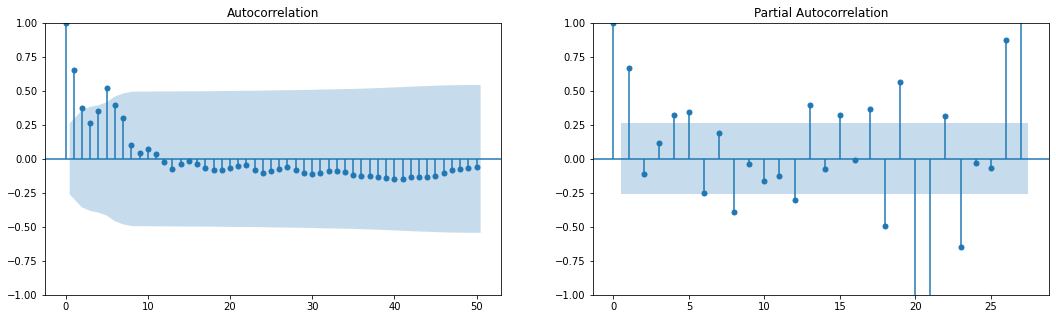

adf:  -3.0788074707524746
p-value:  0.02816180382033301
Critical values:  {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}


In [16]:
plot_acf_pacf(train_df["gdp"].diff(3).dropna())
test = adfuller(train_df["gdp"].diff(3).dropna())
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])

Принимаем вторые разности.

## ARIMA

Построим модель **ARIMA** со следующими параметрами:

- p = 1 
- d = 2 
- q = 1 

In [17]:
arima_model = ARIMA(train_df["gdp"].dropna(), order = (1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Wed, 28 Sep 2022   AIC                           2684.416
Time:                        19:38:51   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+56. Standard errors may be unstable.
"""

Подберем наилучшие параметры с помощью pmdarima

In [18]:
smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         seasonal=False,    # No seasonality
                         d=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True, method='basinhopping',
                         random_state=42, n_jobs=-1)

smodel.summary()

Performing stepwise search to minimize aic


c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=2.41 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.74 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=1.27 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=4.73 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=9.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=15.59 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=16.31 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=14.87 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=13.45 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=19.19 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=3.76 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=2.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.079, Time=7.28 sec
 ARIMA(3,2,1)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1337.891
Date:                Wed, 28 Sep 2022   AIC                           2683.782
Time:                        19:41:48   BIC                           2691.954
Sample:                    01-01-1960   HQIC                          2686.958
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2525      0.230     -1.097      0.273      -0.704       0.199
ar.L2         -0.2150      0.291     -0.740      0.460      -0.785       0.355
ma.L1         -0.8234      0.126     -6.513      0.000      -1.071      -0.576
sigma2      1.835e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               342.07
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):             269.63   Skew:                             1.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+54. Standard errors may be unstable.
"""

Построим модели для значений (2, 2, 2) и (1, 2, 2), для которых auto_arima не выдала AIC

In [19]:
arima_model = ARIMA(train_df["gdp"].dropna(), order = (2, 2, 2))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.986
Date:                Wed, 28 Sep 2022   AIC                           2675.972
Time:                        19:41:49   BIC                           2686.187
Sample:                    01-01-1960   HQIC                          2679.942
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0516      0.067    -15.749      0.000      -1.182      -0.921
ar.L2         -0.3640      0.091     -4.016      0.000      -0.542      -0.186
ma.L1          0.1476      0.112      1.318      0.188      -0.072       0.367
ma.L2         -0.8519      0.123     -6.941      0.000      -1.092      -0.611
sigma2       1.12e+19   1.85e-20   6.05e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               144.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             149.95   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.09e+53. Standard errors may be unstable.
"""

In [20]:
arima_model = ARIMA(train_df["gdp"].dropna(), order = (1, 2, 2))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1336.494
Date:                Wed, 28 Sep 2022   AIC                           2680.988
Time:                        19:41:49   BIC                           2689.160
Sample:                    01-01-1960   HQIC                          2684.164
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4013      0.214      1.875      0.061      -0.018       0.821
ma.L1         -1.5544      0.220     -7.063      0.000      -1.986      -1.123
ma.L2          0.6536      0.191      3.426      0.001       0.280       1.028
sigma2       1.14e+19   2.14e-20   5.34e+38      0.000    1.14e+19    1.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               263.08
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):             289.03   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.57e+54. Standard errors may be unstable.
"""

Выбираем модель с параметрами (2,2,2), так как у нее наименьший AIC из перебранных. Обучим модель с выбранными параметрами.

In [21]:
model = ARIMA(train_df["gdp"].dropna(), order = (2, 2, 2))
model_fit = model.fit()
model_fit.summary()

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.986
Date:                Wed, 28 Sep 2022   AIC                           2675.972
Time:                        19:41:49   BIC                           2686.187
Sample:                    01-01-1960   HQIC                          2679.942
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0516      0.067    -15.749      0.000      -1.182      -0.921
ar.L2         -0.3640      0.091     -4.016      0.000      -0.542      -0.186
ma.L1          0.1476      0.112      1.318      0.188      -0.072       0.367
ma.L2         -0.8519      0.123     -6.941      0.000      -1.092      -0.611
sigma2       1.12e+19   1.85e-20   6.05e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               144.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             149.95   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.09e+53. Standard errors may be unstable.
"""

Выполним предсказания на три года и отобразим результат графически

In [22]:
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = model_fit.predict(start = test_df.index[1], end = test_df.index[-1])


pred_df["gdp"] = data["gdp"]

forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

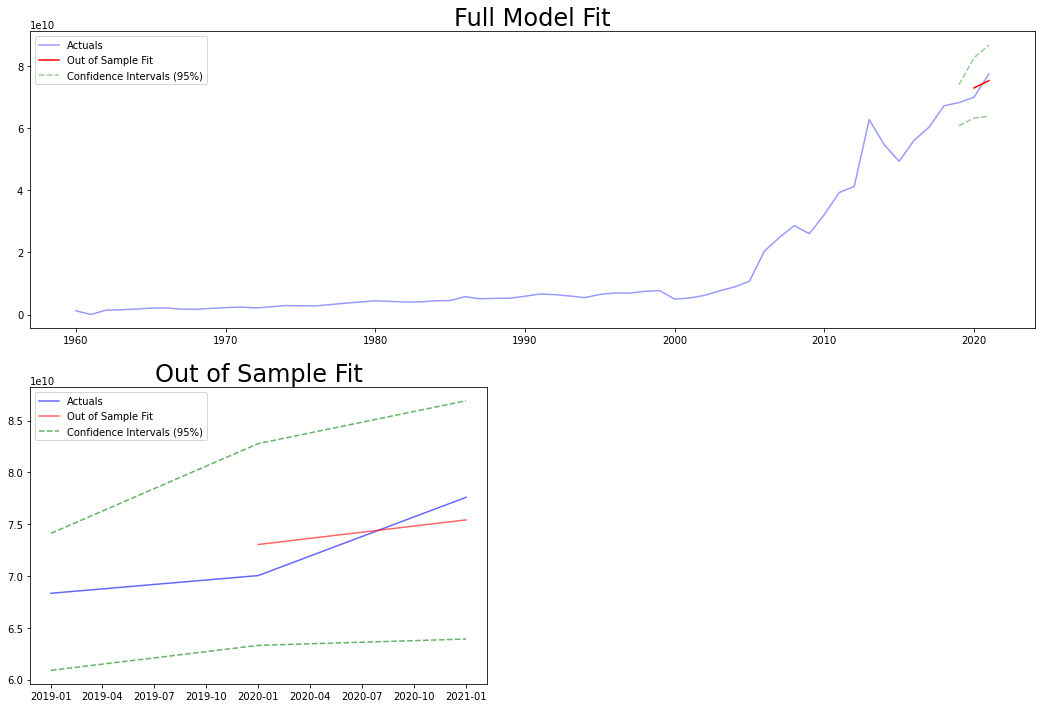

In [23]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["gdp"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

Модель уловила тренд, но не достаточно хорошо.

## Интерполяция

<AxesSubplot:xlabel='year'>

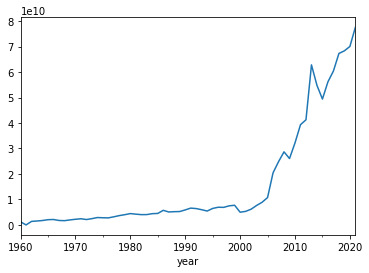

In [24]:
%matplotlib inline 
data.gdp.plot()

Проверим данные на наличие пропущенных дат

In [25]:
data.asfreq(freq='AS')

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [26]:
data.isna().sum()

gdp    0
dtype: int64

Видим (в том числе по графику), что дата 1961-01-01 заполнена нулем. Заменим значение на NaN

In [27]:
data['gdp'] = data['gdp'].apply(lambda x: np.nan if x==0 else x)
data.asfreq(freq='AS')

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,NaN
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Для заполнения пропусков выполнив интерполяцию

In [28]:
data['gdp'] = data['gdp'].interpolate(method='linear')
data.asfreq(freq='AS')

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Отложим последние три года датасета как тестовую выборку для оценки результатов предсказания.

In [29]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

Проверим полученный ряд на стационарность, определим параметры модели (ARIMA/ARMA) и запустим модель

In [30]:
test1 = adfuller(train_df["gdp"])
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  0.8030073326980144
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Продифференцируем ряд

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


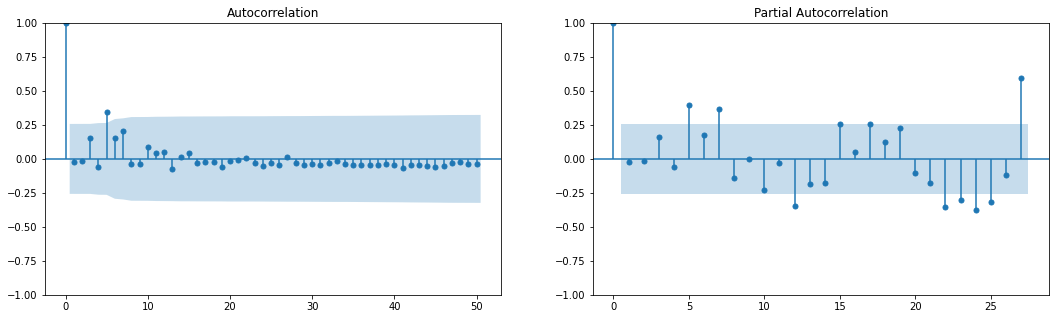

adf:  -1.8255652246436078
p-value:  0.3678451527656304
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


In [31]:
plot_acf_pacf(train_df["gdp"].diff(1).dropna())
test = adfuller(train_df["gdp"].diff(1).dropna())
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


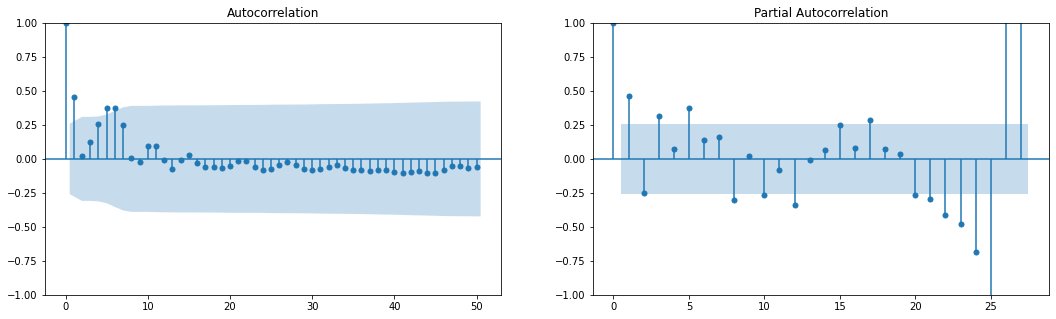

adf:  -3.9998034409491505
p-value:  0.001411540843666124
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}


In [32]:
plot_acf_pacf(train_df["gdp"].diff(2).dropna())
test = adfuller(train_df["gdp"].diff(2).dropna())
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])

Принимаем вторые разности.

Подберем наилучшие параметры.

In [33]:
smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         seasonal=False,    # No seasonality
                         d=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True, method='basinhopping',
                         random_state=42, n_jobs=-1)

smodel.summary()

Performing stepwise search to minimize aic


c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=2.48 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.74 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=1.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=4.41 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=8.49 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=10.48 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=2682.024, Time=15.45 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=13.32 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=2722.161, Time=15.84 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=2684.591, Time=18.69 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.809, Time=19.07 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=2688.600, Time=22.10 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2675.843, Time=14.17 sec
 ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -1332.921
Date:                Wed, 28 Sep 2022   AIC                           2675.843
Time:                        19:45:50   BIC                           2686.058
Sample:                    01-01-1960   HQIC                          2679.813
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0282      0.067    -15.305      0.000      -1.160      -0.897
ar.L2         -0.3472      0.110     -3.160      0.002      -0.562      -0.132
ma.L1          0.1120      0.086      1.308      0.191      -0.056       0.280
ma.L2         -0.8592      0.120     -7.180      0.000      -1.094      -0.625
sigma2       1.12e+19   1.89e-20   5.94e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               172.83
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             446.21   Skew:                             1.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.96e+53. Standard errors may be unstable.
"""

In [34]:
arima_model = ARIMA(train_df["gdp"].dropna(), order = (2, 2, 2))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.819
Date:                Wed, 28 Sep 2022   AIC                           2675.637
Time:                        19:45:50   BIC                           2685.853
Sample:                    01-01-1960   HQIC                          2679.607
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0456      0.068    -15.387      0.000      -1.179      -0.912
ar.L2         -0.3636      0.090     -4.047      0.000      -0.540      -0.188
ma.L1          0.1477      0.110      1.341      0.180      -0.068       0.364
ma.L2         -0.8515      0.122     -6.999      0.000      -1.090      -0.613
sigma2       1.12e+19   1.83e-20   6.11e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               151.25
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             437.56   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+54. Standard errors may be unstable.
"""

In [35]:
arima_model = ARIMA(train_df["gdp"].dropna(), order = (1, 2, 2))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1336.460
Date:                Wed, 28 Sep 2022   AIC                           2680.921
Time:                        19:45:50   BIC                           2689.093
Sample:                    01-01-1960   HQIC                          2684.097
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4036      0.215      1.874      0.061      -0.018       0.826
ma.L1         -1.5552      0.222     -7.020      0.000      -1.989      -1.121
ma.L2          0.6541      0.192      3.406      0.001       0.278       1.031
sigma2       1.14e+19   2.16e-20   5.27e+38      0.000    1.14e+19    1.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               265.12
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):             412.65   Skew:                             1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+54. Standard errors may be unstable.
"""

Выбираем модель с параметрами (2,2,2), так как у нее наименьший AIC из перебранных. Обучим модель с выбранными параметрами.

In [36]:
model = ARIMA(train_df["gdp"].dropna(), order = (2, 2, 2))
model_fit = model.fit()
model_fit.summary()

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.819
Date:                Wed, 28 Sep 2022   AIC                           2675.637
Time:                        19:45:51   BIC                           2685.853
Sample:                    01-01-1960   HQIC                          2679.607
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0456      0.068    -15.387      0.000      -1.179      -0.912
ar.L2         -0.3636      0.090     -4.047      0.000      -0.540      -0.188
ma.L1          0.1477      0.110      1.341      0.180      -0.068       0.364
ma.L2         -0.8515      0.122     -6.999      0.000      -1.090      -0.613
sigma2       1.12e+19   1.83e-20   6.11e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               151.25
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             437.56   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+54. Standard errors may be unstable.
"""

Выполним предсказания на три года и отобразим результат графически

In [37]:
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = model_fit.predict(start = test_df.index[1], end = test_df.index[-1])


pred_df["gdp"] = data["gdp"]

forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

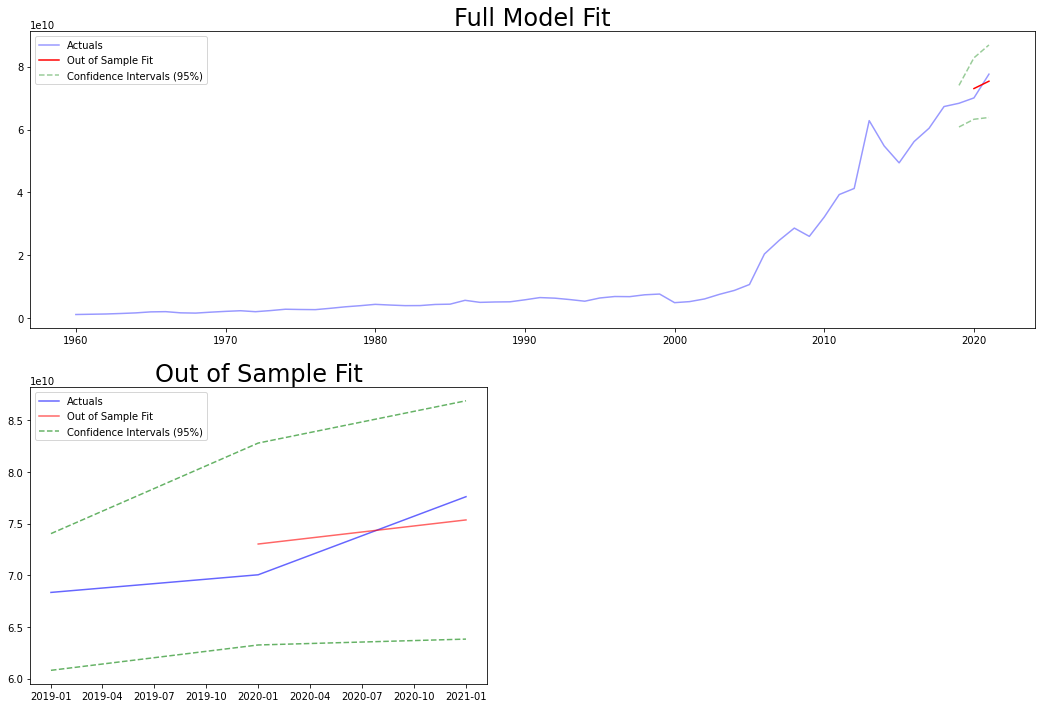

In [38]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["gdp"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

После интерполяции AIC почти не изменился. Это вероятно связано с тем, что нулевое значение было только одно и в самом начале выборки.

## Волатильность 

In [39]:
# data["gdp_vol"] = (data.gdp - data.gdp.shift(1))/data.gdp.shift(1)
data["gdp_vol"] = data.gdp.pct_change(1).mul(100).abs()
data["gdp_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: gdp_vol, dtype: float64

<AxesSubplot:xlabel='year'>

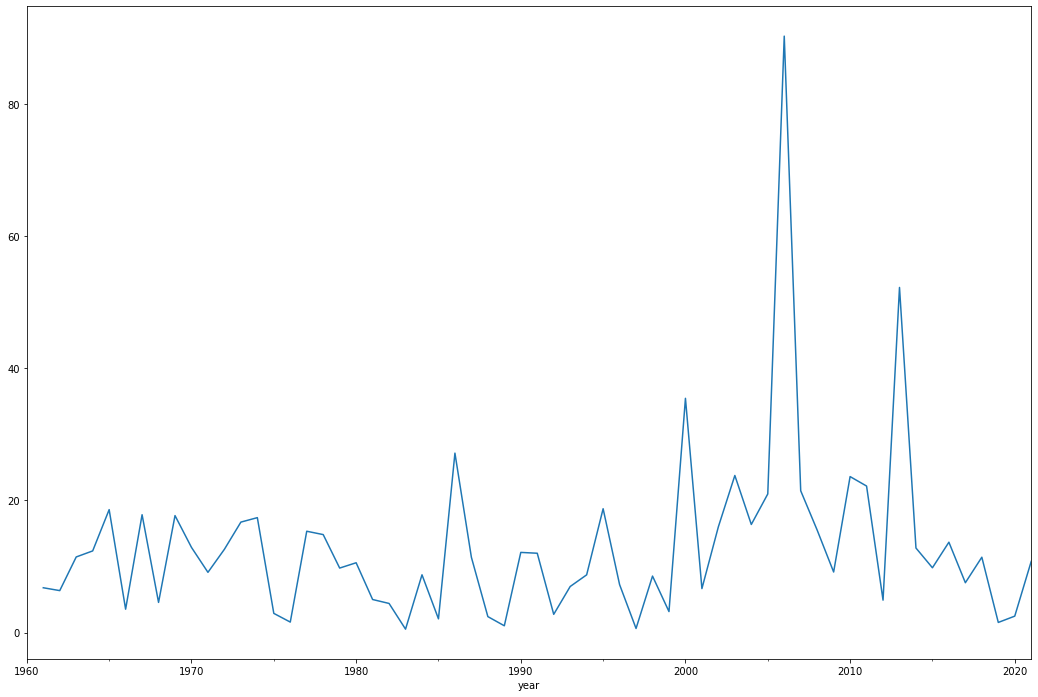

In [40]:
data["gdp_vol"].plot()

In [41]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 2), (3, 2))

Построим коррелограмму частичной автокорелляции.

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


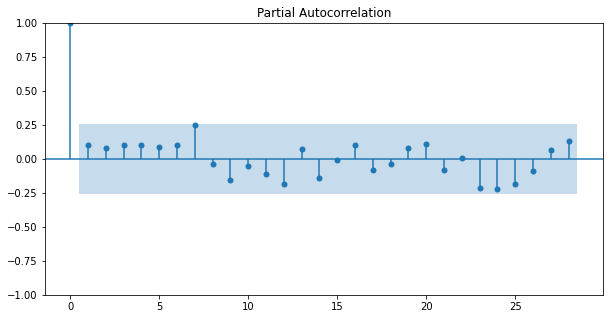

In [42]:
plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.gdp_vol[1:], lags = 28)
plt.show()

In [43]:
adfuller(train_df.gdp_vol[1:])

(-6.725311059553778,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Ряд стационарный.

In [44]:
smodel = pm.auto_arima(train_df["gdp_vol"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         seasonal=False,    # No seasonality
                         d=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True, method='basinhopping',
                         random_state=42, n_jobs=-1)

smodel.summary()

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=474.850, Time=5.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=508.745, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=490.565, Time=0.96 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=499.055, Time=1.63 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=477.153, Time=9.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=477.166, Time=8.81 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=495.666, Time=2.82 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=485.340, Time=7.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=478.611, Time=9.53 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=472.628, Time=5.87 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=472.429, Time=3.64 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=470.923, Time=1.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=472.355, Time=2.46 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 59.041 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:                        SARIMAX   Log Likelihood                -233.462
Date:                Wed, 28 Sep 2022   AIC                            470.923
Time:                        19:46:50   BIC                            475.078
Sample:                    01-01-1960   HQIC                           472.545
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.4593      3.155      4.265      0.000       7.275      19.644
sigma2       183.5567     20.038      9.161      0.000     144.283     222.830
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               796.69
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):              13.07   Skew:                             3.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Построим модель GARCH(1, 1)

Здесь важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит и train и test часть будем использовать актуальные обучающие данные, которые находятся в выборке train_df.

In [45]:
garch_df = pd.DataFrame(data["gdp_vol"].loc[data.index]) 
garch_df.at[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()

In [46]:
model = arch_model(garch_df["gdp_vol"].dropna(), p = 1, q = 1, vol = "GARCH")

# в параметре last_obs указываем последний объект, до которого будем совершать обучение. 
# в нашем случае это до первого объекта из test выборки 

model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18793168771535
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4897.458113019623
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.0018611399729
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.59783393778517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233127643
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [47]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Wed, Sep 28 2022   Df Residuals:                       57
Time:                        19:46:51   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.791  1.663e-06 [  7.279, 17.359]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.737      0.148      0.882 [-44.813, 52.153]
alpha[1]       0.0000  9.201e-02      0.000      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.722e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

Получим предсказания

In [48]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

c:\Users\krygl\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


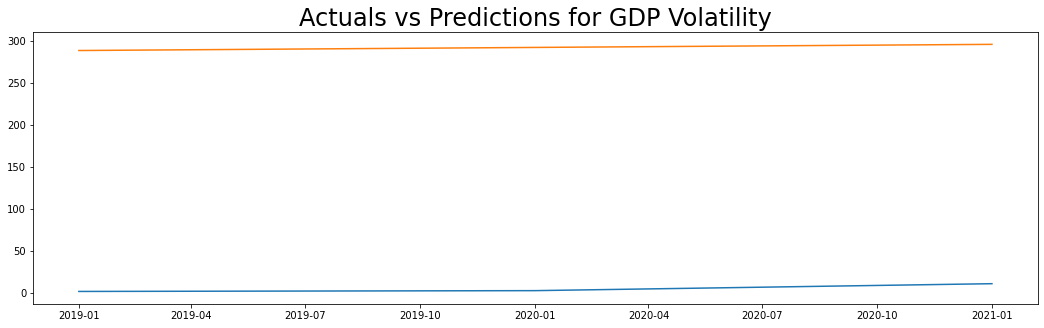

In [49]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gdp_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size = 24)

plt.show()

In [50]:
np.sqrt(mean_squared_error(predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]))

287.2805116645628

Используем линейную регрессию для получения прогноза. Визуализируем полученное предсказание вместе с фактическим значением.

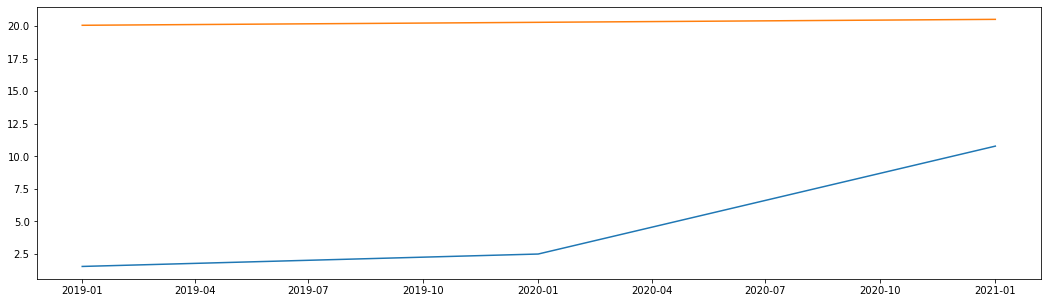

In [51]:
X_train = pd.DataFrame(range(data['gdp_vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['gdp_vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['gdp_vol'].fillna(0)
y_test = test_df['gdp_vol'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))

Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке.